#### Simple PPO Agent (CityLearn)

In [2]:
# Basic imports & versions
import sys, os, json, time, copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import BaseCallback
from utils.env_utils import keep_only_electrical_storage, keep_only_core_observations, PPOTrainLogger, DiscretizeActionWrapper
import citylearn
from citylearn.data import DataSet
from citylearn.citylearn import CityLearnEnv

print('Python:', sys.version.split()[0])
print('Torch :', th.__version__)
print('CityLearn:', citylearn.__version__)

2025-08-27 16:24:04.032235: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-27 16:24:04.047096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756304644.062826  312870 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756304644.067111  312870 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756304644.079421  312870 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Python: 3.11.7
Torch : 2.7.0+cu126
CityLearn: 2.4.1


In [3]:
# Configuration
DATASET_NAME = 'citylearn_challenge_2023_phase_3_1'  # adjust if needed
ROOT_DIR = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
REWARD_FN = {  # CostReward 
    'type': 'citylearn.reward_function.CostReward',
    'attributes': {}
}
PRICING_FILE = 'pricing_germany_2023_june_to_august.csv' 
ACTION_LABELS = ['100%_discharge','50%_discharge','idle','50%_charge','100%_charge']
ONLY_ELECTRICAL_STORAGE = True
EVAL_EPISODES = 10
INT_TO_FRAC = np.array([-1.0, -0.5, 0.0, 0.5, 1.0], dtype=np.float32)


In [4]:
# --- Load schema ---
dataset = DataSet()
schema = dataset.get_schema(DATASET_NAME)
schema['root_directory'] = ROOT_DIR
schema['reward_function'] = REWARD_FN 

price_file = PRICING_FILE # Set pricing file
if 'buildings' not in schema:
    raise RuntimeError("schema does not contain 'buildings' (make sure schema is loaded)")
for bname, bconf in schema['buildings'].items():
    bconf['pricing'] = price_file

schema = keep_only_electrical_storage(schema)
schema = keep_only_core_observations(schema, extra_keep=['carbon_intensity', 'non_shiftable_load'], drop_predictions=False)

INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


In [5]:
# Keep only one building: 1-D action
one_building = "Building_1"
schema_1b = dict(schema)  # shallow copy
schema_1b['buildings'] = {k: v for k, v in schema['buildings'].items() if k == one_building}
if not schema_1b['buildings']:
    raise RuntimeError(f"{one_building} not found in schema['buildings']")

env = CityLearnEnv(schema_1b, central_agent=True) # create env
# check initialization
print('Initial time step:', env.time_step)
print('Number of time steps:', env.time_steps)
print('Central agent:', env.central_agent)
print('Number of buildings:', len(env.buildings))
print('Electrical storage capacity:', {
    b.name: b.electrical_storage.capacity for b in env.buildings
})
print('Action_space [Box(low_limit, high_limit), shape, datatype]:', env.action_space)
print('Number of Observations:', len(env.observations[0]))

/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-27_16-24-07'
Initial time step: 0
Number of time steps: 2208
Central agent: True
Number of buildings: 1
Electrical storage capacity: {'Building_1': 4.0}
Action_space [Box(low_limit, high_limit), shape, datatype]: [Box(-1.0, 1.0, (1,), float32)]
Number of Observations: 6


#### Build & Train PPO

In [6]:
# old:
# env = Monitor(CityLearnPPOWrapper(env))

from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper

log_dir = r'/hkfs/home/haicore/iai/cj9272/logs/ppo'
os.makedirs(log_dir, exist_ok=True)

train_env = NormalizedObservationWrapper(env)
train_env = StableBaselines3Wrapper(train_env)
train_env = DiscretizeActionWrapper(train_env, n_bins=5)
print('Train action_space:', train_env.action_space)

train_env = Monitor(train_env, filename=os.path.join(log_dir, "monitor.csv"))
logger = PPOTrainLogger()
TOTAL_TIMESTEPS = 2208 * 40

model = PPO(
    policy='MlpPolicy',
    env=train_env,
    seed=0, # seed for pseudo random generators
    device='cpu', # ppo is intended to run on cpu
    learning_rate=0.0001,
    #batch_size=200,
    ent_coef=0.5,
    verbose=1, # logging: info
    policy_kwargs=dict(net_arch=[256,256], activation_fn=th.nn.ReLU)
)
start_time = time.time()
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=logger)
print(f"Total time elapsed for {TOTAL_TIMESTEPS} steps: {(time.time()-start_time):.2f} seconds")
model.save("ppo_01")  # saving the model to ppo_01.zip 

Train action_space: Discrete(5)
Using cpu device
Wrapping the env in a DummyVecEnv.
Total time elapsed for 88320 steps: 0.02 seconds


### Quick Evaluation

In [7]:
schema_eval = copy.deepcopy(schema_1b)
eval_env = CityLearnEnv(schema_eval, central_agent=True)
eval_env = NormalizedObservationWrapper(eval_env)
eval_env = StableBaselines3Wrapper(eval_env)
eval_env = DiscretizeActionWrapper(eval_env, n_bins=5)
print('Eval action_space:', eval_env.action_space)

model = PPO.load("ppo_01")  # loading the model from ppo_01.zip             

if hasattr(logger, 'step_df'): logger.step_df.to_csv('train_timesteps.csv', index=False)
if hasattr(logger, 'ep_df'): logger.ep_df.to_csv('episode_rewards.csv', index=False) 

/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-27_16-24-10'
Eval action_space: Discrete(5)


/hkfs/home/haicore/iai/cj9272/citylearn_env/lib64/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [8]:
# Enhanced evaluation: timings, episode length, per-step stats, deterministic toggle.
def evaluate_with_metrics(model, env, episodes=5, deterministic=True, render=False):
    ep_metrics, all_step_rewards, all_kpis, all_actions = [], [], [], []
    t_global_start = time.time()
    for ep in range(1, episodes+1):
        obs, _ = env.reset()
        done = False
        ep_ret, ep_len = 0.0, 0
        step_rewards = []
        action_list = []
        t_ep_start = time.time()
        while not done:
            action, _ = model.predict(obs, deterministic=deterministic)
            # Map discrete id -> fraction [-1..1] and ensure shape (1,) for 1-building
            if isinstance(env.action_space, gym.spaces.Discrete):
                action_logged = np.array([INT_TO_FRAC[int(action)]], dtype=np.float32)
            elif isinstance(env.action_space, gym.spaces.MultiDiscrete):
                a = np.asarray(action, dtype=int)
                action_logged = INT_TO_FRAC[a]
            else:
                action_logged = np.asarray(action, dtype=np.float32)

            action_list.append(action_logged)
            obs, r, terminated, truncated, info = env.step(action)
            done = bool(terminated or truncated)
            ep_ret += float(r)
            step_rewards.append(float(r))
            ep_len += 1
            if render:
                env.render()
        kpis = env.unwrapped.evaluate()
        all_kpis.append(kpis)
        all_actions.append(np.vstack(action_list))
        t_ep = time.time() - t_ep_start
        steps_per_sec = ep_len / max(t_ep, 1e-9)
        ep_metrics.append({
            'episode': ep, 'cumulative reward': ep_ret, 'length': ep_len,
            'mean_reward': ep_ret/ep_len if ep_len else np.nan,
            'min_step_reward': float(np.min(step_rewards)),
            'max_step_reward': float(np.max(step_rewards)),
            'std_step_reward': float(np.std(step_rewards)),
            'steps_per_sec': steps_per_sec, 'wall_time_s': t_ep
        })
        all_step_rewards.extend(step_rewards)
        print(f"[Eval] Ep {ep}/{episodes} return={ep_ret:.3f} len={ep_len} "
              f"mean={ep_ret/ep_len:.3f} time={t_ep:.2f}s speed={steps_per_sec:.1f} steps/s")
        #print("KPIs:", kpis)
    print(f"Total eval time: {time.time()-t_global_start:.2f}s  | Avg/ep: {(time.time()-t_global_start)/episodes:.2f}s")
    metrics_df = pd.DataFrame(ep_metrics)
    display(metrics_df)
    return metrics_df, np.array(all_step_rewards), all_kpis, all_actions

# Deterministic
#metrics_det, step_rewards_det, kpis_det = evaluate_with_metrics(model, eval_env, episodes=EVAL_EPISODES, deterministic=True)

# Stochastic
metrics_stoch, step_rewards_stoch, kpis_stoch, actions_stoch = evaluate_with_metrics(model, eval_env, episodes=EVAL_EPISODES, deterministic=False)

[Eval] Ep 1/10 return=-293.978 len=2207 mean=-0.133 time=121.21s speed=18.2 steps/s
[Eval] Ep 2/10 return=-294.728 len=2207 mean=-0.134 time=121.86s speed=18.1 steps/s
[Eval] Ep 3/10 return=-298.379 len=2207 mean=-0.135 time=121.59s speed=18.2 steps/s
[Eval] Ep 4/10 return=-295.700 len=2207 mean=-0.134 time=121.78s speed=18.1 steps/s
[Eval] Ep 5/10 return=-295.757 len=2207 mean=-0.134 time=121.83s speed=18.1 steps/s
[Eval] Ep 6/10 return=-297.329 len=2207 mean=-0.135 time=122.03s speed=18.1 steps/s
[Eval] Ep 7/10 return=-296.390 len=2207 mean=-0.134 time=130.71s speed=16.9 steps/s
[Eval] Ep 8/10 return=-297.106 len=2207 mean=-0.135 time=144.47s speed=15.3 steps/s
[Eval] Ep 9/10 return=-296.158 len=2207 mean=-0.134 time=168.26s speed=13.1 steps/s
[Eval] Ep 10/10 return=-294.010 len=2207 mean=-0.133 time=122.87s speed=18.0 steps/s
Total eval time: 1296.66s  | Avg/ep: 129.67s


,episode,cumulative reward,length,mean_reward,min_step_reward,max_step_reward,std_step_reward,steps_per_sec,wall_time_s
0,1,-293.977728,2207,-0.133202,-2.033061,0.0,0.174976,18.208111,121.209719
1,2,-294.727719,2207,-0.133542,-1.788633,0.0,0.174344,18.110694,121.861700
2,3,-298.378543,2207,-0.135196,-1.757477,0.0,0.174414,18.151698,121.586422
3,4,-295.699652,2207,-0.133983,-1.729649,0.0,0.173348,18.123519,121.775465
4,5,-295.756606,2207,-0.134008,-1.568949,0.0,0.174972,18.115853,121.827002
5,6,-297.328546,2207,-0.134721,-1.757477,0.0,0.178383,18.085471,122.031658
6,7,-296.390322,2207,-0.134296,-1.758275,0.0,0.176770,16.885320,130.705255
7,8,-297.106208,2207,-0.134620,-2.020118,0.0,0.179510,15.276789,144.467534
8,9,-296.157761,2207,-0.134190,-1.757477,0.0,0.176232,13.116840,168.256984
9,10,-294.009520,2207,-0.133217,-2.407078,0.0,0.172383,17.962654,122.866030


In [9]:
# Quick learning check on training episodes
if hasattr(logger, 'ep_df') and len(logger.ep_df):
    ep_df = logger.ep_df
    first_n, last_n = 10, 10
    first_mean = ep_df['return'].head(first_n).mean()
    last_mean  = ep_df['return'].tail(last_n).mean()
    print(f'First {first_n} ep mean return: {first_mean:.3f}')
    print(f'Last  {last_n} ep mean return: {last_mean:.3f}')
    print('Learning indicator (last - first):', f'{(last_mean-first_mean):.3f}')
else:
    print('No episode returns in logger.ep_df')


No episode returns in logger.ep_df


#### Plots

Plotting actions for building: Building_1 (index 0)


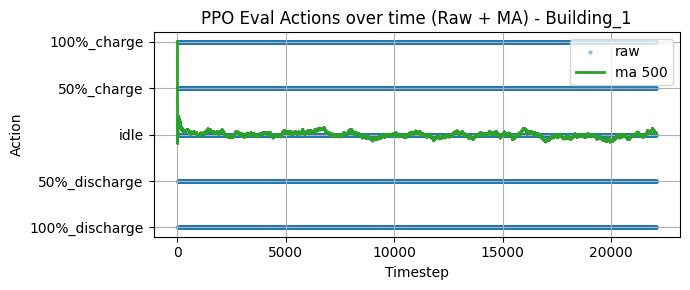

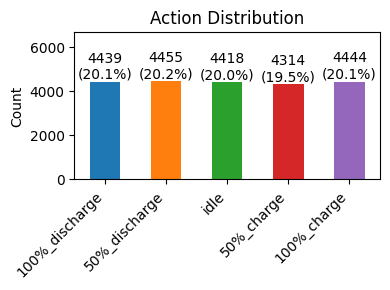

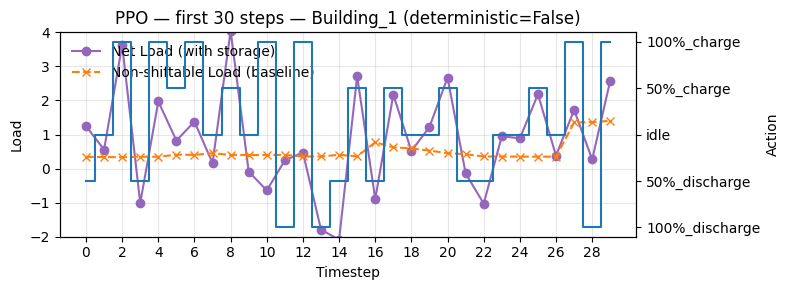

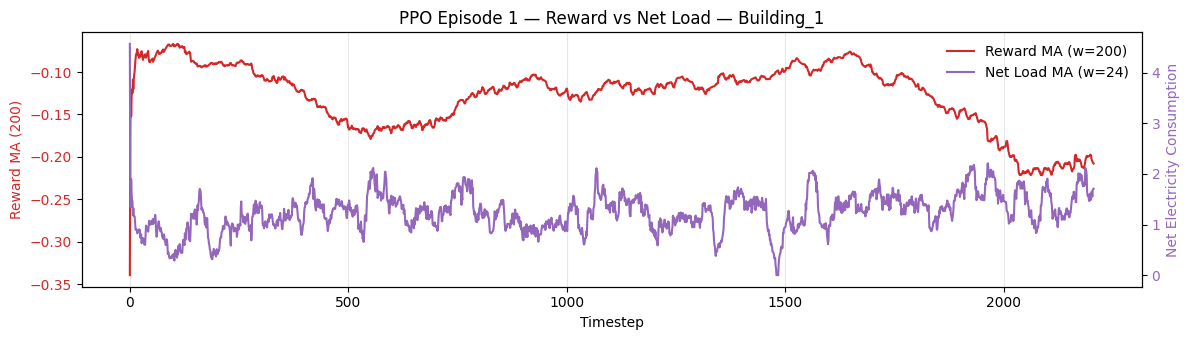

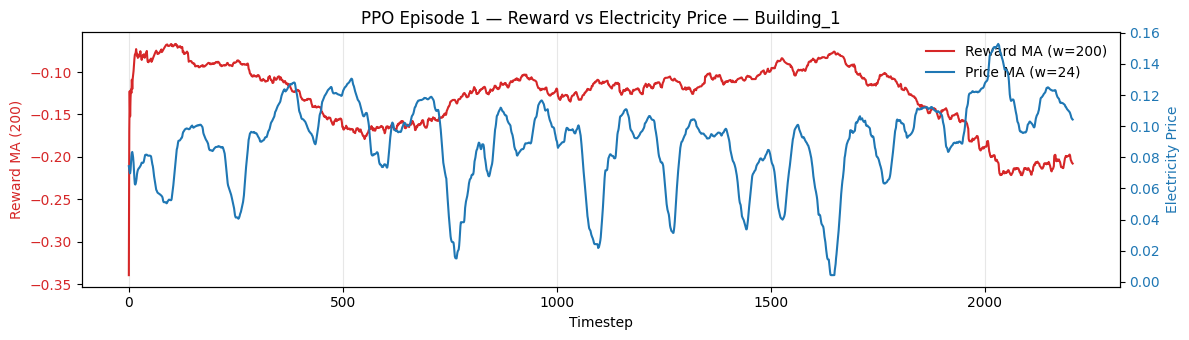

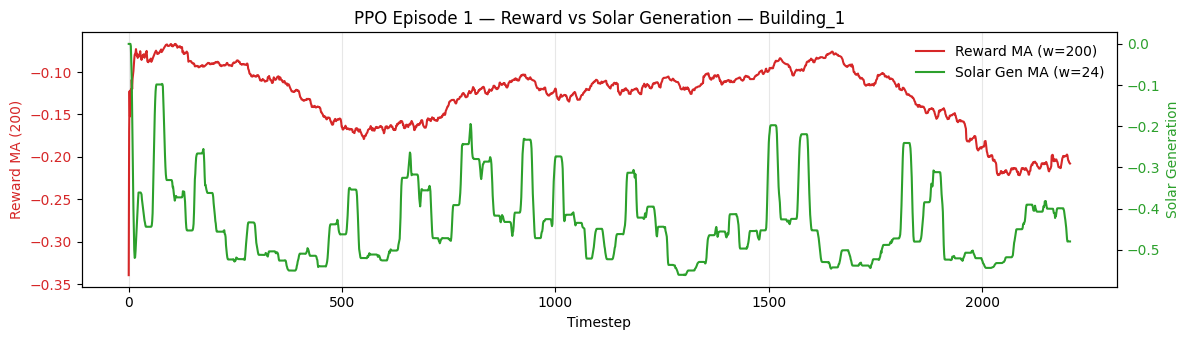

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from citylearn.citylearn import CityLearnEnv

# Choose a building to visualize
building_name = 'Building_1'
bld_names = [b.name for b in eval_env.unwrapped.buildings]
if building_name not in bld_names:
    building_name = bld_names[0]
b_idx = bld_names.index(building_name)
print(f'Plotting actions for building: {building_name} (index {b_idx})')

# Flatten evaluated actions across episodes -> shape (total_steps, n_actions)
actions_arr = np.concatenate(actions_stoch, axis=0)  # each item shape (ep_len, n_actions)
n_actions = actions_arr.shape[1]
total_steps = actions_arr.shape[0]

# Build episode boundaries from metrics
ep_lengths = metrics_stoch['length'].to_numpy()
ep_offsets = np.cumsum(np.concatenate([[0], ep_lengths[:-1]]))
hour_index = np.arange(total_steps)

# Load pricing for the chosen building
price_file = schema['buildings'][building_name]['pricing']
price_path = os.path.join(ROOT_DIR, price_file)
prc = pd.read_csv(price_path)
T = len(prc)  # usually 2208

# Helper: map continuous action to 5 RBC-like labels by nearest of [-1,-0.5,0,0.5,1]
bin_centers = np.array([-1.0, -0.5, 0.0, 0.5, 1.0])
def cont_to_label(vals):
    idx = np.argmin(np.abs(vals[..., None] - bin_centers[None, ...]), axis=-1)
    return idx  # 0..4


# ----- Plot 1: Actions over Time (for selected building) -----
window = 500
act_series = actions_arr[:, b_idx]
act_ma = pd.Series(act_series).rolling(window, min_periods=1).mean().to_numpy()

plt.figure(figsize=(7,3))
plt.scatter(hour_index, act_series, s=5, alpha=0.35, label='raw')
plt.plot(hour_index, act_ma, color='C2', lw=2, label=f'ma {window}')
plt.title(f'PPO Eval Actions over time (Raw + MA) - {building_name}')
plt.xlabel('Timestep'); plt.ylabel('Action'); plt.grid(True); plt.legend(loc='upper right')
# Label y-axis with discrete action names
ax = plt.gca()
ax.set_yticks(INT_TO_FRAC.tolist())
ax.set_yticklabels(ACTION_LABELS)
plt.tight_layout(); plt.show()


# ----- Plot 2: Action Distribution (quantized to 5 bins like RBC) -----
labels_idx = cont_to_label(act_series)
counts = pd.Series(labels_idx).value_counts().reindex(range(5)).fillna(0).astype(int)
plt.figure(figsize=(4,3))
ax = counts.plot(kind='bar', color=['C0','C1','C2','C3','C4'])
ax.set_xticklabels(ACTION_LABELS, rotation=45, ha='right')
total = counts.sum()
ax.bar_label(ax.containers[0], labels=[f'{int(v)}\n({v/total:.1%})' for v in counts.values])
ax.set_ylim(0, counts.max()*1.5)
plt.ylabel('Count'); plt.title('Action Distribution'); plt.tight_layout(); plt.show()


# ----- Plot 3: Reward vs Net Load -----
# 5-bin mapping used by DiscretizeActionWrapper
INT_TO_FRAC = np.array([-1.0, -0.5, 0.0, 0.5, 1.0], dtype=np.float32)

def unwrap_to_citylearn(env):
    cur, seen = env, set()
    while cur is not None and id(cur) not in seen:
        seen.add(id(cur))
        if isinstance(cur, CityLearnEnv):
            return cur
        cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
    raise RuntimeError("CityLearnEnv not found inside wrappers.")

def capture_ep_series(model, env, building_name="Building_1", deterministic=True, max_steps=None):
    """Run one episode (or first max_steps) and capture per-step action, reward, and true arrays from base env."""
    base = unwrap_to_citylearn(env)

    # pick building idx
    bld_names = [b.name for b in base.buildings]
    if building_name not in bld_names:
        building_name = bld_names[0]
    b_idx = bld_names.index(building_name)
    b = base.buildings[b_idx]

    obs, _ = env.reset()
    done = False
    t, a_id_list, a_frac_list, rew_list = [], [], [], []
    net_true, nsl_true, price_true, solar_true = [], [], [], []

    steps = 0
    while not done and (max_steps is None or steps < max_steps):
        act, _ = model.predict(obs, deterministic=deterministic)

        # unwrap action to id for the target building
        if isinstance(env.action_space, gym.spaces.Discrete):
            a_id = int(act)
        elif isinstance(env.action_space, gym.spaces.MultiDiscrete):
            a_id = int(np.asarray(act).reshape(-1)[b_idx])
        else:
            # continuous -> nearest 5-bin id
            val = float(np.asarray(act).reshape(-1)[b_idx])
            centers = INT_TO_FRAC
            a_id = int(np.argmin(np.abs(centers - val)))

        a_frac = float(INT_TO_FRAC[a_id])

        # step the wrapped env to keep wrappers consistent
        obs, r, terminated, truncated, _ = env.step(act)
        done = bool(terminated or truncated)

        # read from unwrapped arrays; prefer non-zero current index
        ts_now = b.time_step
        ts_idx = max(0, ts_now - 1)

        net_now = float(b.net_electricity_consumption[ts_now])
        net_idx = float(b.net_electricity_consumption[ts_idx])
        net_use = net_idx if net_now == 0.0 else net_now

        nsl_now = float(b.non_shiftable_load[ts_now])
        nsl_idx = float(b.non_shiftable_load[ts_idx])
        nsl_use = nsl_idx if nsl_now == 0.0 else nsl_now

        price = float(b.pricing.electricity_pricing[ts_now]) if b.pricing is not None else np.nan
        solar = float(b.solar_generation[ts_now])

        t.append(steps)
        a_id_list.append(a_id)
        a_frac_list.append(a_frac)
        rew_list.append(float(r))
        net_true.append(net_use)
        nsl_true.append(nsl_use)
        price_true.append(price)
        solar_true.append(solar)

        steps += 1

    df = pd.DataFrame({
        't': np.arange(len(t)),
        'action_id': a_id_list,
        'action_frac': a_frac_list,
        'reward': rew_list,
        'net_load': net_true,
        'non_shiftable_load': nsl_true,
        'price': price_true,
        'solar_generation': solar_true,
    })
    return df, building_name

def plot_first_30_steps_actions_vs_loads_ppo(model, env, building_name="Building_1", deterministic=True):
    """Plot first 30 steps: net load vs non-shiftable load with action (discrete bins in [-1..1])."""
    df20, bname = capture_ep_series(model, env, building_name, deterministic=deterministic, max_steps=30)

    t = df20['t'].to_numpy()
    net = df20['net_load'].to_numpy()
    nsl = df20['non_shiftable_load'].to_numpy()
    act = df20['action_frac'].to_numpy()

    # Quick summary for sanity
    counts = df20['action_id'].value_counts().sort_index()

    fig, ax1 = plt.subplots(figsize=(8, 3))
    ax1.plot(t, net, color='C4', marker='o', label='Net Load (with storage)')
    ax1.plot(t, nsl, color='C1', ls='--', marker='x', label='Non-shiftable Load (baseline)')
    ax1.set_xlabel('Timestep')
    ax1.set_xticks(t[::2])
    ax1.set_ylabel('Load')
    ax1.set_ylim(-2, 4)  # enforce requested load range
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left', frameon=False)
    
    ax2 = ax1.twinx()
    ax2.step(t, act, where='mid', color='C0', label='Action')
    ax2.set_ylabel('Action')
    ax2.set_ylim(-1.1, 1.1)
    ax2.set_yticks(INT_TO_FRAC.tolist())
    try:
        ax2.set_yticklabels(ACTION_LABELS)
    except Exception:
        ax2.set_yticklabels(['100%_discharge','50%_discharge','idle','50%_charge','100%_charge'])
    
    plt.title(f'PPO — first 30 steps — {bname} (deterministic={deterministic})')
    plt.tight_layout()
    plt.show()

plot_first_30_steps_actions_vs_loads_ppo(model, eval_env, building_name="Building_1", deterministic=False)


# ----- Plot 4,5,6: Reward vs Series -----
def ppo_ep1_reward_vs_series(model, env, building_name="Building_1", deterministic=True):
    df, bname = capture_ep_series(model, env, building_name, deterministic=deterministic, max_steps=None)

    window_reward = 200
    window_x = 24
    t = df['t'].to_numpy()
    reward_ma = pd.Series(df['reward']).rolling(window_reward, min_periods=1).mean().to_numpy()
    price_ma  = pd.Series(df['price']).rolling(window_x, min_periods=1).mean().to_numpy()
    solar_ma  = pd.Series(df['solar_generation']).rolling(window_x, min_periods=1).mean().to_numpy()
    net_ma    = pd.Series(df['net_load']).rolling(window_x, min_periods=1).mean().to_numpy()

    # 4) Reward vs Net Load
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, net_ma, color='C4', label=f'Net Load MA (w={window_x})')
    ax2.set_ylabel('Net Electricity Consumption', color='C4'); ax2.tick_params(axis='y', labelcolor='C4')
    lines = ax1.get_lines() + ax2.get_lines()
    ax1.legend(lines, [l.get_label() for l in lines], loc='upper right', frameon=False)
    ax1.set_title(f'PPO Episode 1 — Reward vs Net Load — {bname}')
    plt.tight_layout(); plt.show()


    # 5) Reward vs Electricity Price
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, price_ma, color='C0', label=f'Price MA (w={window_x})')
    ax2.set_ylabel('Electricity Price', color='C0'); ax2.tick_params(axis='y', labelcolor='C0')
    lines = ax1.get_lines() + ax2.get_lines()
    ax1.legend(lines, [l.get_label() for l in lines], loc='upper right', frameon=False)
    ax1.set_title(f'PPO Episode 1 — Reward vs Electricity Price — {bname}')
    plt.tight_layout(); plt.show()


    # 6) Reward vs Solar Generation
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, solar_ma, color='C2', label=f'Solar Gen MA (w={window_x})')
    ax2.set_ylabel('Solar Generation', color='C2'); ax2.tick_params(axis='y', labelcolor='C2')
    lines = ax1.get_lines() + ax2.get_lines()
    ax1.legend(lines, [l.get_label() for l in lines], loc='upper right', frameon=False)
    ax1.set_title(f'PPO Episode 1 — Reward vs Solar Generation — {bname}')
    plt.tight_layout(); plt.show()

ppo_ep1_reward_vs_series(model, eval_env, building_name="Building_1", deterministic=False)

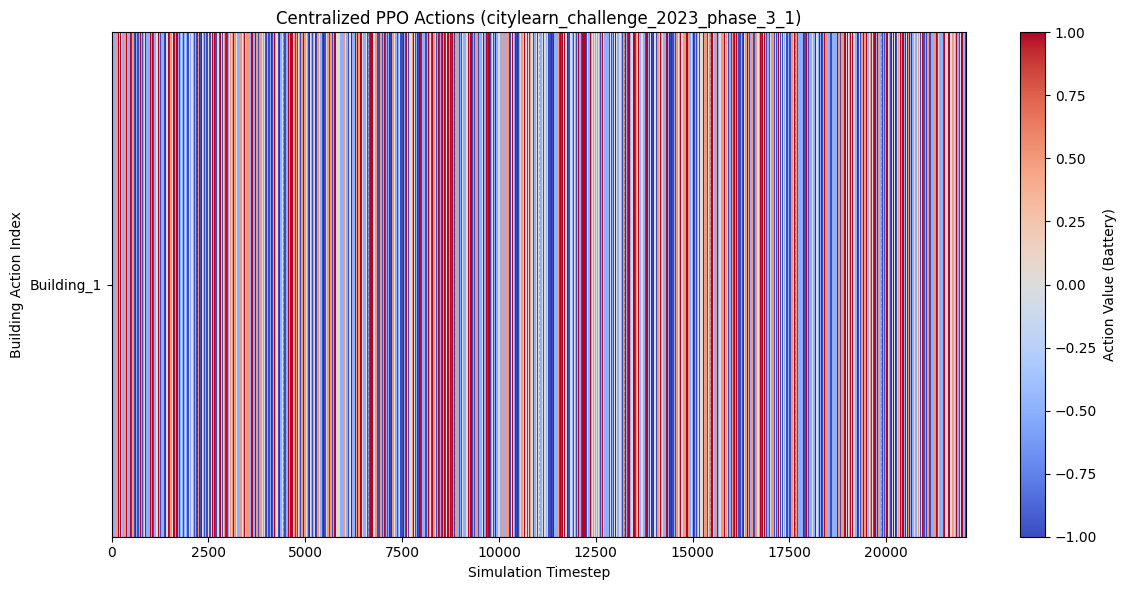

In [11]:
# Heatmap of centralized PPO actions across buildings and timesteps (eval episodes concatenated)
import os
import numpy as np
import matplotlib.pyplot as plt

# Require evaluated actions
assert 'actions_stoch' in globals() and len(actions_stoch) > 0, "Run evaluate_with_metrics first."

# Flatten list[(ep_len, n_actions)] -> (total_steps, n_actions)
actions_arr = np.concatenate(actions_stoch, axis=0)
n_steps, n_actions = actions_arr.shape

# Episode boundaries for vertical lines
ep_lengths = metrics_stoch['length'].to_numpy() if 'metrics_stoch' in globals() else np.array([n_steps])
ep_offsets = np.cumsum(np.concatenate([[0], ep_lengths[:-1]]))

# Building labels
bld_names = [b.name for b in eval_env.unwrapped.buildings]
if len(bld_names) != n_actions:
    bld_names = [f'Act {i}' for i in range(n_actions)]

# Output dir
results_dir = os.path.join(os.getcwd(), 'results')
os.makedirs(results_dir, exist_ok=True)

plt.figure(figsize=(12, 6))
plt.imshow(actions_arr.T, aspect='auto', interpolation='none', cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Action Value (Battery)')
plt.xlabel('Simulation Timestep')
plt.ylabel('Building Action Index')
plt.yticks(np.arange(n_actions), bld_names)

# Mark episode boundaries
for off in ep_offsets[1:]:
    plt.axvline(off, color='k', ls='--', lw=0.8, alpha=0.2)

plt.title(f'Centralized PPO Actions ({DATASET_NAME})')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'ppo_actions_heatmap.png'), dpi=150)
plt.show()